# Libraries

In [1]:
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression

# Import & View Data

In [2]:
train = pd.read_csv("./train_data_withlabels.csv")
test = pd.read_csv("./test_data_nolabels.csv")

In [3]:
train.head()

,dataid,localminute,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,target
0,1,2018-01-02 01:00:00,0.416,0.0,0.0,0.0,0.0,0,0.0,0
1,2,2018-01-02 01:01:00,0.416,0.0,0.0,0.0,0.0,0,0.0,0
2,3,2018-01-02 01:02:00,0.416,0.0,0.0,0.0,0.0,0,0.0,0
3,4,2018-01-02 01:03:00,0.415,0.0,0.0,0.0,0.0,0,0.0,0
4,5,2018-01-02 01:04:00,0.416,0.0,0.0,0.0,0.0,0,0.0,0


In [4]:
train.describe()

,dataid,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,target
count,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000
mean,209904.500000,1.138576,1.149224,0.000179,1.138460,0.904516,9.999983,3.171293,0.054411
std,121188.275241,1.551522,1.612034,1.979740,1.026167,0.741364,5.407102,2.393255,0.226826
min,1.000000,-4.780000,0.000000,-13.602000,-2.867713,0.000000,0.000000,0.000000,0.000000
25%,104952.750000,0.277000,0.096000,-0.245000,0.398881,0.185816,7.000000,1.016000,0.000000
50%,209904.500000,0.414000,0.231000,-0.001000,0.798396,0.900660,9.000000,2.895000,0.000000
75%,314856.250000,1.177000,2.279000,0.219000,1.566542,1.314512,12.000000,4.210000,0.000000
max,419808.000000,15.404000,14.912000,14.912000,7.931208,5.897778,92.000000,15.404000,1.000000


Here we see the data type of the `target` as binary, thus we will use a classifier

In [5]:
train.target.unique()

array([0, 1])

# Preprocessing

## Reduce Data

* reduce the number of attributes for training
    * remove `dataid` as it is not relevant to `target` result

In [6]:
train = train.iloc[:, 1:]

## Check and Handle Missing Values

From the count we can see that there are no missing values as the row count is still the same as our count in `describe` above

In [7]:
train_nulls = pd.notnull(train)
train = train[train_nulls]

In [8]:
train.describe()

,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,target
count,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000
mean,1.138576,1.149224,0.000179,1.138460,0.904516,9.999983,3.171293,0.054411
std,1.551522,1.612034,1.979740,1.026167,0.741364,5.407102,2.393255,0.226826
min,-4.780000,0.000000,-13.602000,-2.867713,0.000000,0.000000,0.000000,0.000000
25%,0.277000,0.096000,-0.245000,0.398881,0.185816,7.000000,1.016000,0.000000
50%,0.414000,0.231000,-0.001000,0.798396,0.900660,9.000000,2.895000,0.000000
75%,1.177000,2.279000,0.219000,1.566542,1.314512,12.000000,4.210000,0.000000
max,15.404000,14.912000,14.912000,7.931208,5.897778,92.000000,15.404000,1.000000


## Create new Features from Existing One

* separate `localminute` to 
    * month
    * date
    * weekday
    * hour
    * minute
 
 year and second will not be included as it would not be relevant to this analysis with all the data are of one value

In [9]:
# change type from string to datetime object
train.localminute = pd.to_datetime(train.localminute)

# create new columns
train['month'] = train.localminute.dt.month
train['date'] = train.localminute.dt.day
train['weekday'] = train.localminute.dt.weekday
train['hour'] = train.localminute.dt.hour
train['minute'] = train.localminute.dt.minute

# remove localminute column
train = train.iloc[:, 1:]

In [10]:
# move target column just for ease
target = train.pop('target')
train['target'] = target

In [11]:
train.describe()

,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,month,date,weekday,hour,minute,target
count,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000
mean,1.138576,1.149224,0.000179,1.138460,0.904516,9.999983,3.171293,5.367168,15.371884,2.997370,11.491596,29.499314,0.054411
std,1.551522,1.612034,1.979740,1.026167,0.741364,5.407102,2.393255,2.777114,8.681037,1.991407,6.920450,17.317885,0.226826
min,-4.780000,0.000000,-13.602000,-2.867713,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.277000,0.096000,-0.245000,0.398881,0.185816,7.000000,1.016000,3.000000,8.000000,1.000000,5.000000,14.000000,0.000000
50%,0.414000,0.231000,-0.001000,0.798396,0.900660,9.000000,2.895000,5.000000,15.000000,3.000000,11.000000,29.000000,0.000000
75%,1.177000,2.279000,0.219000,1.566542,1.314512,12.000000,4.210000,8.000000,23.000000,5.000000,17.000000,44.000000,0.000000
max,15.404000,14.912000,14.912000,7.931208,5.897778,92.000000,15.404000,10.000000,31.000000,6.000000,23.000000,59.000000,1.000000


## Normalize Data

In [12]:
# get column names
col_names = train.columns.to_list()

# use sklearn to normalize data
train_normal = pd.DataFrame(MinMaxScaler().fit_transform(train))

# rename columns
train_normal.columns = col_names

In [13]:
train_normal.head()

,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,month,date,weekday,hour,minute,target
0,0.257432,0.0,0.477029,0.265556,0.0,0.0,0.0,0.0,0.033333,0.166667,0.043478,0.000000,0.0
1,0.257432,0.0,0.477029,0.265556,0.0,0.0,0.0,0.0,0.033333,0.166667,0.043478,0.016949,0.0
2,0.257432,0.0,0.477029,0.265556,0.0,0.0,0.0,0.0,0.033333,0.166667,0.043478,0.033898,0.0
3,0.257382,0.0,0.477029,0.265556,0.0,0.0,0.0,0.0,0.033333,0.166667,0.043478,0.050847,0.0
4,0.257432,0.0,0.477029,0.265556,0.0,0.0,0.0,0.0,0.033333,0.166667,0.043478,0.067797,0.0


# Creating Model

* Logistic Regression
* KNN Neighbours
* Random Forest

In [14]:
# split to train and validation
validation, train_x = train_test_split(train_normal, test_size = 0.9, train_size = 0.1)

## Logistic Regression

In [15]:
train_x

,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,month,date,weekday,hour,minute,second,target
30856,0.248117,0.240813,0.351091,0.357568,0.221842,0.086957,0.269735,0.000000,0.733333,0.166667,0.478261,0.271186,0.0,0.0
133541,0.261147,0.157658,0.559480,0.348946,0.149534,0.108696,0.193326,0.333333,0.100000,0.333333,0.782609,0.694915,0.0,0.0
310584,0.250396,0.166309,0.390054,0.457468,0.267188,0.065217,0.386523,0.777778,0.133333,1.000000,0.739130,0.406780,0.0,0.0
275560,0.262089,0.145319,0.553027,0.372969,0.194356,0.119565,0.209296,0.666667,0.366667,0.500000,0.391304,0.677966,0.0,0.0
64263,0.253319,0.046204,0.501192,0.291806,0.027651,0.130435,0.064659,0.111111,0.466667,0.500000,0.695652,0.050847,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383956,0.246829,0.298216,0.632987,0.337770,0.245957,0.086957,0.311867,0.888889,0.800000,0.166667,0.695652,0.271186,0.0,0.0
279882,0.397642,0.176234,0.569194,0.419757,0.223946,0.086957,0.239483,0.666667,0.466667,1.000000,0.391304,0.711864,0.0,0.0
294212,0.448969,0.270386,0.618433,0.753238,0.255601,0.086957,0.465334,0.666667,0.800000,0.333333,0.347826,0.542373,0.0,1.0
291137,0.252626,0.009858,0.482184,0.337515,0.161382,0.130435,0.183783,0.666667,0.733333,0.000000,0.217391,0.288136,0.0,0.0


In [16]:
validation

,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,month,date,weekday,hour,minute,second,target
125675,0.244154,0.006974,0.480676,0.294646,0.050743,0.097826,0.150480,0.222222,0.966667,0.666667,0.304348,0.593220,0.0,0.0
242310,0.245491,0.109777,0.534439,0.340552,0.177329,0.141304,0.204622,0.555556,0.600000,0.166667,0.304348,0.508475,0.0,0.0
185154,0.380351,0.139418,0.404117,0.328567,0.143400,0.163043,0.202934,0.444444,0.300000,0.500000,0.608696,0.915254,0.0,0.0
409998,0.254162,0.009321,0.481904,0.363697,0.181896,0.130435,0.199883,1.000000,0.400000,0.833333,0.782609,0.305085,0.0,0.0
133040,0.260702,0.150215,0.555587,0.324336,0.102860,0.086957,0.181122,0.333333,0.100000,0.333333,0.434783,0.338983,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76298,0.245442,0.003085,0.475416,0.291113,0.028822,0.086957,0.051415,0.111111,0.766667,0.833333,0.000000,0.644068,0.0,0.0
124567,0.250595,0.001878,0.478011,0.283683,0.011769,0.097826,0.019995,0.222222,0.933333,0.500000,0.565217,0.118644,0.0,0.0
333952,0.245442,0.001609,0.476187,0.323775,0.140064,0.130435,0.181771,0.777778,0.666667,0.166667,0.956522,0.881356,0.0,0.0
143145,0.512881,0.260864,0.340605,0.680718,0.435921,0.065217,0.605687,0.333333,0.333333,0.333333,0.434783,0.762712,0.0,0.0


In [35]:
train.head()

,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,month,date,weekday,hour,minute,second,target
0,0.416,0.0,0.0,0.0,0.0,0,0.0,1,2,1,1,0,0,0
1,0.416,0.0,0.0,0.0,0.0,0,0.0,1,2,1,1,1,0,0
2,0.416,0.0,0.0,0.0,0.0,0,0.0,1,2,1,1,2,0,0
3,0.415,0.0,0.0,0.0,0.0,0,0.0,1,2,1,1,3,0,0
4,0.416,0.0,0.0,0.0,0.0,0,0.0,1,2,1,1,4,0,0


In [15]:
train.tail()

,dataid,localminute,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,target
419803,419804,2018-10-20 13:43:00,0.703,5.641,-5.641,1.487960,1.748301,15,6.457,0
419804,419805,2018-10-20 13:44:00,0.704,0.797,-0.797,1.432129,1.690799,15,6.457,0
419805,419806,2018-10-20 13:45:00,0.700,4.850,-4.850,1.424267,1.693774,15,6.457,0
419806,419807,2018-10-20 13:46:00,0.678,2.811,-2.811,1.376257,1.652556,15,6.457,0
419807,419808,2018-10-20 13:47:00,0.677,1.727,-1.727,1.348406,1.645047,7,6.457,0


In [13]:
test.head()

,dataid,localminute,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak
0,419809,2018-10-20 13:48:00,0.675,6.063,-6.063,1.331287,1.645901,5,6.457
1,419810,2018-10-20 13:49:00,0.680,0.853,-0.853,1.271267,1.565692,5,5.946
2,419811,2018-10-20 13:50:00,0.717,3.585,-3.585,1.262495,1.568303,5,5.946
3,419812,2018-10-20 13:51:00,1.043,3.408,-3.408,1.225921,1.548015,5,5.946
4,419813,2018-10-20 13:52:00,0.718,0.845,-0.845,1.192208,1.531441,5,5.946


# Inference Task

## Correlation

In [14]:
c = train_normal.corr()
c

,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,month,date,weekday,hour,minute,target
total_load,1.000000,0.236253,-0.000043,0.715982,0.476937,0.079730,0.536047,0.192887,-0.005194,-0.009190,0.202791,-0.005308,0.576940
ab_diff,0.236253,1.000000,0.018650,0.464145,0.610513,0.002259,0.585830,0.171594,0.015568,-0.016386,0.176159,0.000473,0.175344
re_diff,-0.000043,0.018650,1.000000,-0.000014,0.036247,-0.017137,0.033963,0.000176,-0.000869,0.000404,-0.046177,-0.002670,0.033362
window_mean,0.715982,0.464145,-0.000014,1.000000,0.705160,0.103743,0.791608,0.291650,-0.007436,-0.013699,0.304480,0.001044,0.529645
window_dev,0.476937,0.610513,0.036247,0.705160,1.000000,0.063664,0.889104,0.366448,0.036779,-0.022655,0.218210,0.000187,0.324742
window_crossing_point,0.079730,0.002259,-0.017137,0.103743,0.063664,1.000000,0.133075,0.003197,-0.002690,-0.017787,-0.083431,-0.000076,-0.105124
window_peak,0.536047,0.585830,0.033963,0.791608,0.889104,0.133075,1.000000,0.317198,0.025627,-0.026728,0.232181,0.000355,0.357295
month,0.192887,0.171594,0.000176,0.291650,0.366448,0.003197,0.317198,1.000000,-0.069376,0.003534,-0.002795,-0.000066,0.003377
date,-0.005194,0.015568,-0.000869,-0.007436,0.036779,-0.002690,0.025627,-0.069376,1.000000,-0.002391,-0.001140,-0.000021,-0.008135
weekday,-0.009190,-0.016386,0.000404,-0.013699,-0.022655,-0.017787,-0.026728,0.003534,-0.002391,1.000000,-0.001698,-0.000040,-0.003506


<AxesSubplot:>

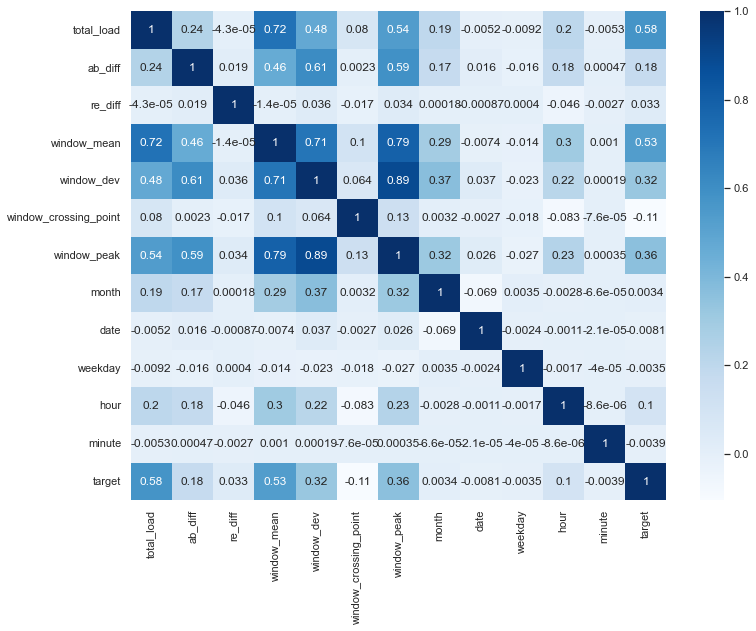

In [18]:
sns.set(rc={'figure.figsize':(12,9)})

sns.heatmap(c, cmap="Blues", annot=True)

In [37]:
c.iloc[:, -1:].reindex(c.target.abs().sort_values(ascending = False).index).iloc[1:, :]

,target
total_load,0.576940
window_mean,0.529645
window_peak,0.357295
window_dev,0.324742
ab_diff,0.175344
window_crossing_point,-0.105124
hour,0.100808
re_diff,0.033362
date,-0.008135
minute,-0.003857


# References

* https://www.altexsoft.com/blog/datascience/preparing-your-dataset-for-machine-learning-8-basic-techniques-that-make-your-data-better/

* 